In [1]:
################################################################################################################################################
# Modelling gross private domestic investment (GPDI) from Federal Reserve Economic Datasets:
# Vector autoregression (VAR) model analyzes relationships between multiple time series variables, how they interact over time
# Multivariate time series model for GPDI and unemployment rate variables
################################################################################################################################################
# import libraries
import glob
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm

In [2]:
########################################################################
# pre-processing: read in all files into dfs within a dict, clean and plot
########################################################################
folder="C:/Users/bcm9/Documents/Py_code/Data/FRED/"
filelist = glob.glob(os.path.join(folder, "*.xls"))
print(filelist)

['C:/Users/bcm9/Documents/Py_code/Data/FRED\\BOPGSTB.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\CPALTT01USM657N.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\GDPC1.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\GPDI.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\PCECC96.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\UNRATE.xls']


In [3]:
# create empty dictionary 
df_dict = {}

# append datasets into the list
for file in filelist:
    df = pd.read_excel(file)
    # get the name of the csv without the '.csv' extension
    filename = os.path.splitext(os.path.basename(file))[0]
    df_dict[filename] = df

In [4]:
for key in df_dict.keys():
    df = df_dict[key]
    df = df.loc[10:, :].copy()
    df['date'] = pd.to_datetime(df['FRED Graph Observations'])
    df_dict[key] = df

In [5]:
# drop all original date format from df and rename columns for later identification
for key in df_dict.keys():
    df_dict[key] = df_dict[key].drop('FRED Graph Observations', axis=1)
    df_dict[key]=df_dict[key].rename(columns={"Unnamed: 1": key})

In [6]:
##########################################################################################################################################################
# Build model
##########################################################################################################################################################
# merge data into a dataframe, indexing by date
ts = df_dict['GPDI'].merge(df_dict['UNRATE'], on='date')
ts=ts.set_index(['date'])

# convert to numpy array for model
ts = ts[['GPDI', 'UNRATE']].to_numpy(dtype=np.int)

# print(ts)

C:\Users\bcm9\AppData\Local\Temp\ipykernel_5608\909304427.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ts = ts[['GPDI', 'UNRATE']].to_numpy(dtype=np.int)


In [7]:
# Create VAR model
model = sm.tsa.VAR(ts)

# Fit VAR model to data
results = model.fit()

# show summary of model
print(results.summary())

# interpretation: 
# L1.y1 coeff =  effect of the lagged value of GPDI on the current value of GPDI, after controlling for unemployment rate. A positive coefficient suggests that high values of GPDI in one period are likely to be followed by high values of GPDI in the next period.
# L1.y2 coeff = effect of the lagged value of unemployment rate on the current value of GPDI, after controlling GPDI. A positive coefficient suggests a positive relationship between unemployment rate and GPDI.

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, Mar, 2023
Time:                     09:37:17
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.81684
Nobs:                     299.000    HQIC:                   7.77231
Log likelihood:          -2000.04    FPE:                    2304.43
AIC:                      7.74259    Det(Omega_mle):         2258.87
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       -56.800081        12.444857           -4.564           0.000
L1.y1         1.009403         0.003144          321.072           0.000
L1.y2        11.510791         2.162934            5.322           0.000

Results for equation 

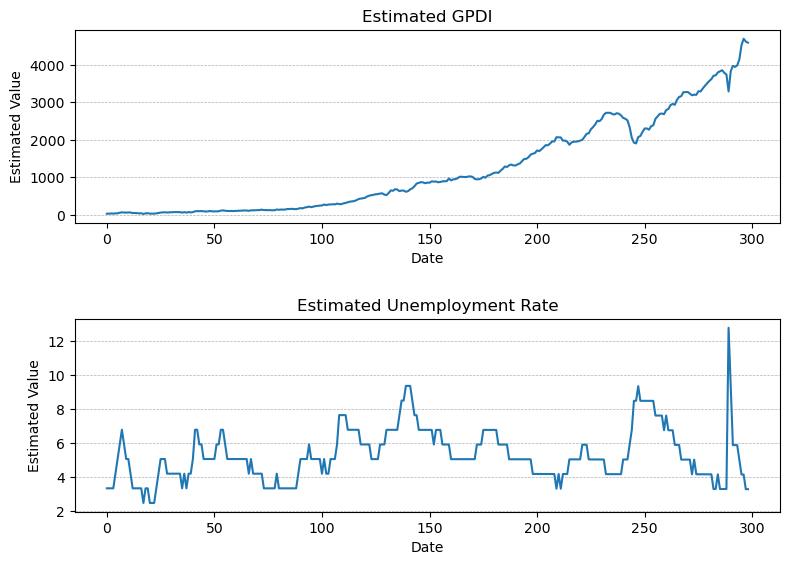

In [8]:
# Extract predicted GPDI and unemployment rate accounting for the lagged values in the system,
# including the effects of unemployment rate on GPDI, and plot
gpdi = results.fittedvalues[:,0]
unemployment = results.fittedvalues[:,1]

# creat figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# estimated GPDI
sns.lineplot(data=gpdi, ax=axs[0])
axs[0].set_title('Estimated GPDI')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Estimated Value')
axs[0].grid(axis='y', linestyle='--', linewidth=0.5)

# estimated unemployment rate
sns.lineplot(data=unemployment, ax=axs[1])
axs[1].set_title('Estimated Unemployment Rate')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Estimated Value')
axs[1].grid(axis='y', linestyle='--', linewidth=0.5)

# adjust layout, spacing of subplots
plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()

In [9]:
# predictions for the next n time steps
# forecast applies the VAR coefficients to the lagged values of each variable to where the forecast begins 
nsteps=15
forecast = results.forecast(model.y, steps=nsteps)
print(forecast)

[[4.68457996e+03 3.27444290e+00]
 [4.70952190e+03 3.51119454e+00]
 [4.73742358e+03 3.71536144e+00]
 [4.76793774e+03 3.89135769e+00]
 [4.80076470e+03 4.04299884e+00]
 [4.83564585e+03 4.17358303e+00]
 [4.87235812e+03 4.28596119e+00]
 [4.91070917e+03 4.38259763e+00]
 [4.95053321e+03 4.46562250e+00]
 [4.99168742e+03 4.53687707e+00]
 [5.03404880e+03 4.59795293e+00]
 [5.07751155e+03 4.65022580e+00]
 [5.12198470e+03 4.69488485e+00]
 [5.16739011e+03 4.73295796e+00]
 [5.21366072e+03 4.76533362e+00]]


C:\Users\bcm9\AppData\Local\Temp\ipykernel_5608\3594147624.py:4: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  forecast = results.forecast(model.y, steps=nsteps)
